In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
import time
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import cv2
import keras


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
if torch.cuda.is_available():
    dev= 'cuda:0'
else:
    dev = 'cpu'
torch.cuda.is_available()

True

In [4]:
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import pandas as pd


(240, 240, 155, 2)
[0. 1. 2. 3.]


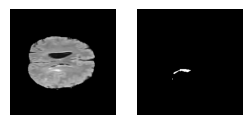

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpm2teblqu.PNG'


In [5]:
#/kaggle/input/task01braintumour/Task01_BrainTumour/imagesTr/BRATS_001.nii
i=1
train1 = nib.load(f"/kaggle/input/task01braintumour/Task01_BrainTumour/imagesTr/BRATS_{i:03}.nii")
train_data1 = train1.get_fdata()[:,:,:,0:2]
test1 = nib.load(f"/kaggle/input/task01braintumour/Task01_BrainTumour/imagesTr/BRATS_{i:03}.nii")
test_data1 =test1.get_fdata()
lab1 = nib.load(f"/kaggle/input/task01braintumour/Task01_BrainTumour/labelsTr/BRATS_{i:03}.nii")
lab_data = lab1.get_fdata()
print(train_data1.shape)
#classes
print(np.unique(lab_data))
fig, ax = plt.subplots(1,2, figsize=(3,3))
ax[0].imshow(train_data1[:,:,100,0], cmap="gray")
ax[1].imshow(lab_data[:,:,100], cmap="gray")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()
test = np.array(test_data1)
test1 = np.stack(test,axis=1)
test = Image.fromarray(lab_data[:,:,11])
test.show()
label1 = torch.zeros((240,240,240,4))
#label1[:,:,14,0] = torch.where(lab_data[:,:,14]==0, torch.tensor(1), torch.tensor(0))

140


Text(0.5, 1.0, 'showing tumor seg')

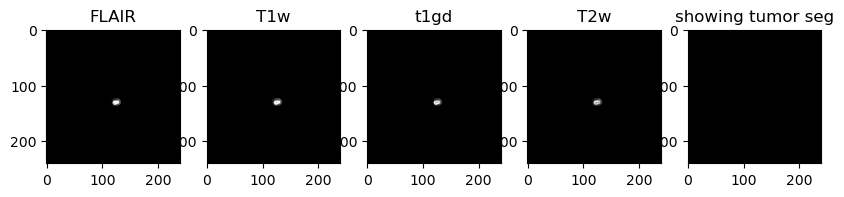

In [6]:
import random
#{'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'},
figure, (p1,p2,p3,p4,p5) = plt.subplots(1, 5,figsize =(10,20))
#choosing random slice....
rand_slice = random.randint(0,train_data1.shape[2])
print(rand_slice)
p1.imshow(test_data1[:,:,rand_slice,0],cmap = "gray")
p1.set_title("FLAIR")
p2.imshow(test_data1[:,:,rand_slice,1],cmap = "gray")
p2.set_title("T1w")
p3.imshow(test_data1[:,:,rand_slice,2],cmap = "gray")
p3.set_title("t1gd")
p4.imshow(test_data1[:,:,rand_slice,3],cmap = "gray")
p4.set_title("T2w")
# ploting segment of tumor
p5.imshow(lab_data[:,:,rand_slice],cmap="gray")
p5.set_title("showing tumor seg")

#we will use Flair and T1gd- 0,2

In [7]:
train_data_flair = train1.get_fdata()[:,:,:,0]
train_data_t1gd = train1.get_fdata()[:,:,:,2]

train_data1 = np.array(train_data_flair)
np.shape(train_data_flair)

(240, 240, 155)

In [8]:
path = "/kaggle/input/task01braintumour/Task01_BrainTumour"
list_path = os.listdir(path)
list_path.sort()
list_path


['dataset.json', 'imagesTr', 'imagesTs', 'labelsTr']

In [9]:
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

In [10]:
class Mydataset(Dataset):
    def __init__(self, path, list_path,img_size):
        super(Mydataset, self).__init__()
        self.path = path
        self.trainnum = list_path
        self.train = []
        self.train_path = []
        self.lab = []
        self.lab_path = []
        self.train_path = os.listdir(os.path.join(path,list_path[1]))
        self.train_path.sort()
        self.lab_path = os.listdir(os.path.join(path,list_path[3]))
        self.lab_path.sort()
        self.IMG_SIZE=img_size
        #print(self.train_path)
        
        
    def __len__(self):
        return len(self.train_path)
    
    def __getitem__(self,idx):
        img = nib.load(os.path.join(self.path,self.trainnum[1],self.train_path[idx]))
        #print(os.path.join(self.path,self.trainnum[1],self.train_path[idx]))
        img = img.get_fdata()
        img = np.array(img[:,:,:,[0,2]])
        img = np.float32(img)
        #img = torch.from_numpy(img)
        #img = transforms.ToPILImage(img)
        
        #img = Image.fromarray(img)
        
        label = nib.load(os.path.join(self.path,list_path[3],self.lab_path[idx]))
        label = label.get_fdata()
        label = np.array(label)
        #print(np.shape(label))
        #label = torch.from_numpy(label)
        #label = transforms.ToPILImage(label)
        #label =  Image.fromarray(label)
        
        #label = np.long(label)
        label = np.float32(label)
        
        update_img = np.zeros((self.IMG_SIZE, self.IMG_SIZE,75,2))
        update_lab = np.zeros((self.IMG_SIZE,self.IMG_SIZE,75))
        
        update_img[:,:,:,0] = cv2.resize(img[:,:,60:135,0], (self.IMG_SIZE,self.IMG_SIZE))
        update_img[:,:,:,1] = cv2.resize(img[:,:,60:135,1], (self.IMG_SIZE, self.IMG_SIZE))
        update_lab[:,:,:] = cv2.resize(label[:,:,60:135],(self.IMG_SIZE,self.IMG_SIZE))
        update_img = torch.Tensor(np.einsum("ijkl -> lijk",update_img))
        update_lab=np.float32(update_lab)
        label = torch.from_numpy(update_lab)
        update_img = np.float32(update_img)
        update_img = torch.from_numpy(update_img)
        label1 = torch.zeros((self.IMG_SIZE,self.IMG_SIZE,75,4))
        #print(label1.size())
        #one one hot encoding 
        label1[:,:,:,0] = torch.where(label[:,:,:]==0, torch.tensor(1), torch.tensor(0))
        label1[:,:,:,1] = torch.where(label[:,:,:]==1, torch.tensor(1), torch.tensor(0))
        label1[:,:,:,2] = torch.where(label[:,:,:]==2, torch.tensor(1), torch.tensor(0))
        label1[:,:,:,3] = torch.where(label[:,:,:]==3, torch.tensor(1), torch.tensor(0))
        label1 = torch.Tensor(np.einsum("ijkl->lijk",label1.numpy()))

        #Resizing images.
        
        return (update_img, label1)
                
                

    
                       
                          
                       
    
        
            


In [11]:
data = Mydataset(path, list_path,128)
np.shape(data[1][1])
type(data[1][1])

torch.Tensor

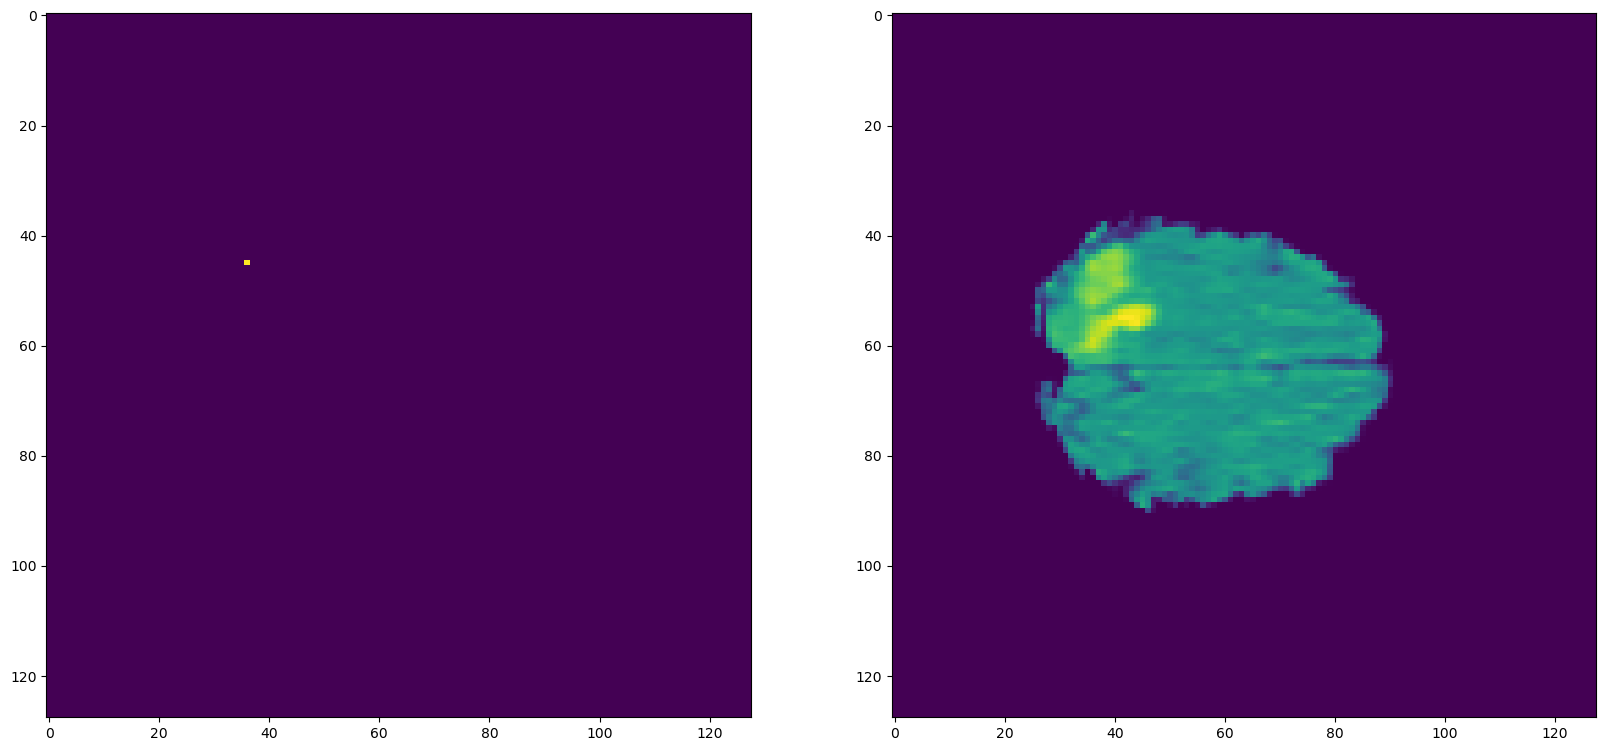

In [12]:
test_lab= data[1][1].cpu()
img = data[1][0].cpu()
hi = tf.one_hot(lab_data,4)

#test_lab = np.array(test_lab)
#test_lab = Image.fromarray(test_lab[:,:,90,2])
fig,ax= plt.subplots(1,2,figsize=(20,20))
#after one one hot encoding
ax[0].imshow(test_lab[2,:,:,60])
ax[1].imshow(img[0,:,:,60])
#plt.plot(lab_data[:,:,120])
plt.show()

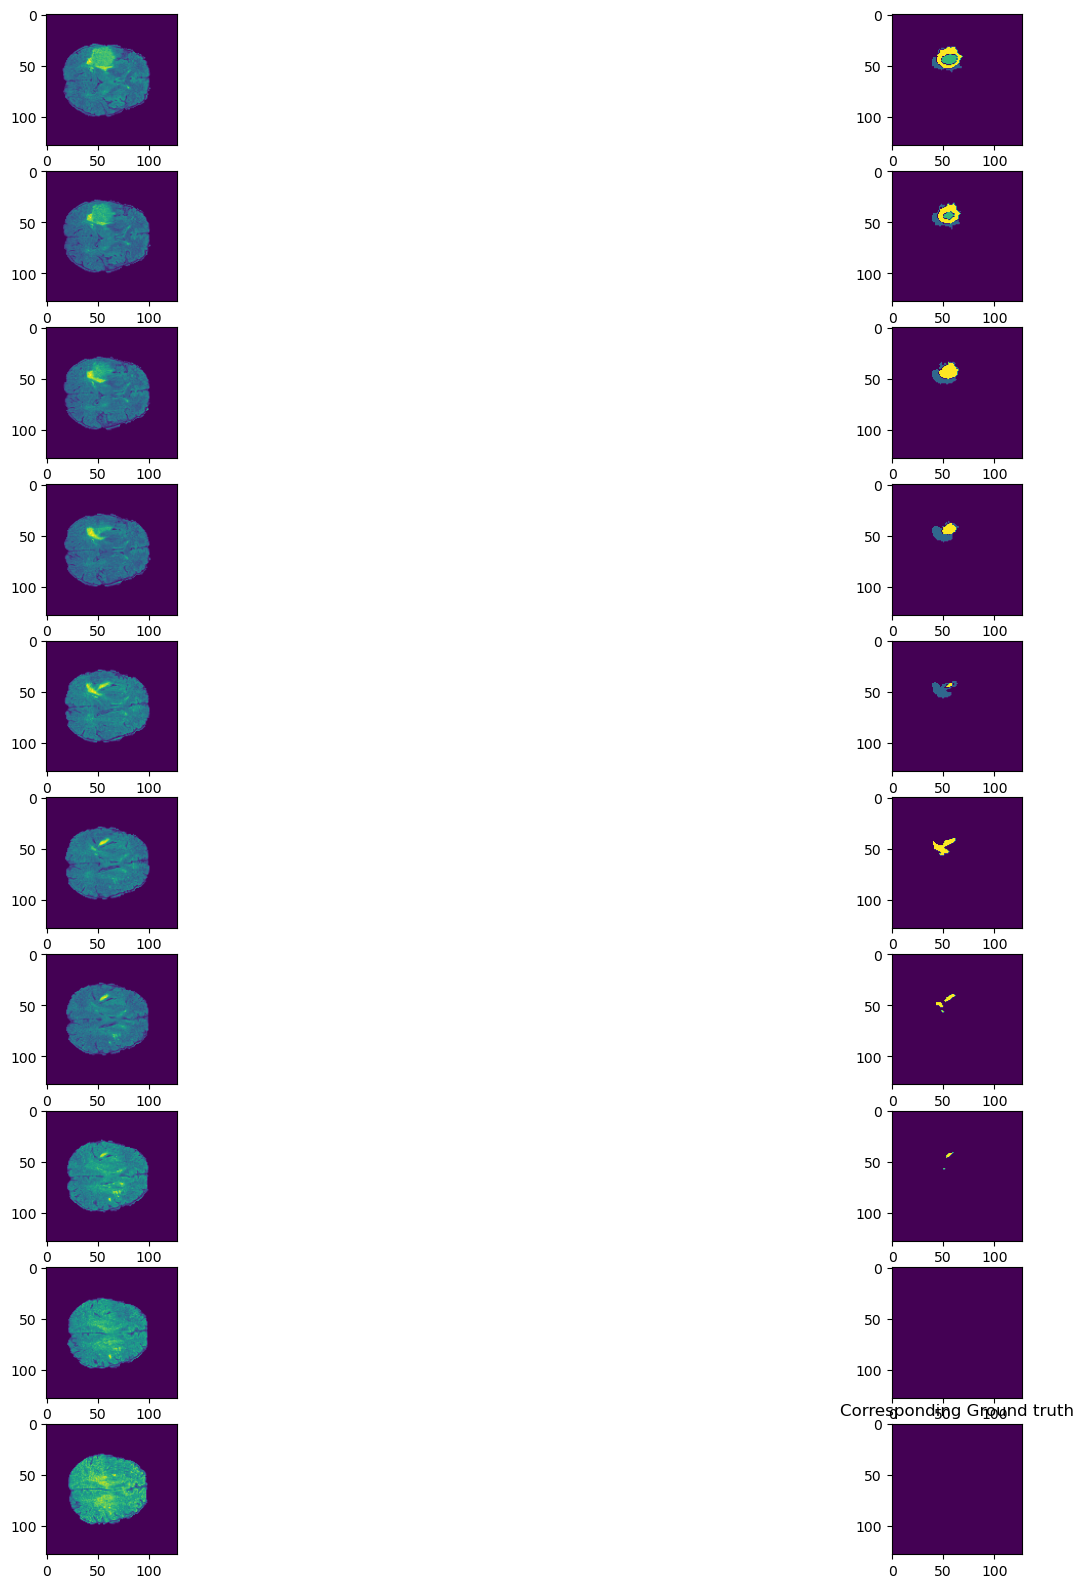

In [13]:
#t_path = os.path.join(path,list_path)


k=20
i=0
fig,ax = plt.subplots(10,2,figsize=(20,20))
for i in range(0,10):
   
    img = data[432][0].cpu()
    plt.title("Brain MRI Scans")
    ax[i,0].imshow(img[0,:,:,k])
    lab = data[432][1].cpu()
    store = np.argmax(lab.numpy(),axis=0)
    plt.title("Corresponding Ground truth")
    ax[i,1].imshow(store[:,:,k])
    k=k+2


In [16]:
#split the data into train and test-
train_size = int(0.01 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])
print(len(train_data))
print(len(test_data))

4
480


In [17]:
train_dl =  DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=False, drop_last=False)
print(len(train_dl))
test_dl = DataLoader(test_data, batch_size=2, shuffle=True, pin_memory=False, drop_last=False)
print(len(test_dl))
train_dl

1
240


In [18]:
for batch in train_dl:
    image, lable = batch
    print(np.shape(image))
    print(np.shape(lable))
    break

torch.Size([4, 2, 128, 128, 75])
torch.Size([4, 4, 128, 128, 75])


In [19]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        #print(np.shape(inputs))
        #print(np.shape(skip))
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    
class unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(2, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 4, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        

        return outputs

In [20]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [21]:
#!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

In [22]:
import gc
del model
gc.collect()

torch.cuda.empty_cache()
print(torch.cuda.mem_get_info())

(958136320, 15843721216)


In [23]:
model = unet()
model.to(dev)

unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), str

In [25]:
#if USE_GPU and torch.cuda.is_available():
#for batch in train_dl:
#for batch in train_dl:
img, lable = batch
out = model(img[:,:,:,:,1].to(dev))
pred_out = F.softmax(out,dim=1)
print(np.shape(pred_out))
#print(np.shape(label_slice))
#break


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 14.76 GiB total capacity; 536.50 MiB already allocated; 17.75 MiB free; 576.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
#Dice is also working fine-
def calculate_dice(pred , targets):
        smooth = 1.
        
        # inputs = F.softmax(pred, dim=1) 
        inputs = pred   
           
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


In [25]:
def cal_iou(pred, target):
    smooth = 1e-5
    target = torch.from_numpy(np.argmax(target.cpu().numpy(),axis=1))
    pred = torch.from_numpy(np.argmax(pred.cpu().numpy(),axis=1))
    intersection = (pred * target).sum(dim=(1,2))
    union = (pred + target).sum(dim=(1,2))
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou.mean()


In [35]:
def cal_accuracy(pred, target):
    target = torch.from_numpy(np.argmax(target.cpu().numpy(),axis=1))
    pred = torch.from_numpy(np.argmax(pred.cpu().numpy(),axis=1))
    correct = pred.eq(target).sum()
    acc = correct.float() / pred.numel()
    return acc

In [59]:
cal_accuracy(pred,label_slice)

tensor(0.9859)

In [54]:
lr = 0.001
epochs = 2
# Choosing the loss function to be Mean Square Error Loss
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
#write learning rate scheduler code for cylcic learning rate-
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [55]:
len(train_dl)

1

tensor(0.9896)
tensor(0.9896)
tensor(0.9899)
tensor(0.9894)
tensor(0.9885)
tensor(0.9890)
tensor(0.9882)
tensor(0.9883)
tensor(0.9884)
tensor(0.9879)
tensor(0.9877)
tensor(0.9875)
tensor(0.9875)
tensor(0.9873)
tensor(0.9866)


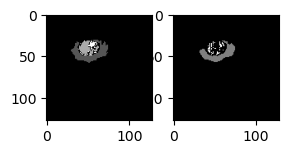

Epoch: 1/2 | Training Time: 0.8177808284759521 | Training Loss: 0.03425577208399773 | Training Accuracy: 0.9883697628974915 | Training Jaccard: 0.9770975708961487 | Training Dice: 0.011755494400858879
Epoch got completed
tensor(0.9897)
tensor(0.9898)
tensor(0.9900)
tensor(0.9895)
tensor(0.9886)
tensor(0.9892)
tensor(0.9883)
tensor(0.9884)
tensor(0.9885)
tensor(0.9881)
tensor(0.9880)
tensor(0.9877)
tensor(0.9877)
tensor(0.9874)
tensor(0.9867)


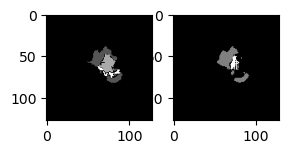

Epoch: 2/2 | Training Time: 0.844860315322876 | Training Loss: 0.03401150926947594 | Training Accuracy: 0.9885172247886658 | Training Jaccard: 0.977299153804779 | Training Dice: 0.011647224426269531
Epoch got completed
tensor(0.9898)
tensor(0.9898)
tensor(0.9901)
tensor(0.9896)
tensor(0.9887)
tensor(0.9893)
tensor(0.9885)
tensor(0.9885)
tensor(0.9886)
tensor(0.9883)
tensor(0.9881)
tensor(0.9878)
tensor(0.9879)
tensor(0.9876)
tensor(0.9868)


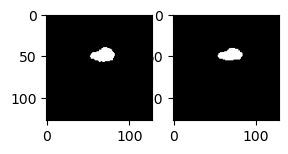

Epoch: 3/2 | Training Time: 0.8102620323499043 | Training Loss: 0.033790608992179234 | Training Accuracy: 0.988629162311554 | Training Jaccard: 0.9774320125579834 | Training Dice: 0.011577395722270012
Epoch got completed


In [62]:
import logging
logging.basicConfig(filename='training.log', level=logging.INFO)
train_loss = []
train_acc = []
train_jacc = []
train_dice = []

for e in range(epochs+1):
    start = time.time()

    epoch_loss = 0
    epoch_acc = 0
    epoch_iou = 0
    epoch_dice = 0
    
    for batch in train_dl:
        img, label = batch
        img = img.float()
        #running only 15 slices to check
        # total of 1*4*15 images are used in training in singal epoch
        for i in range(10,25):
            pred = model(img[:,:,:,:,i])
           # print(i)
           # print(np.shape(pred))
            #print(np.shape(label))
            label_slice = (label[:,:,:,:,i].float())
            #print(np.shape label_slice))
            #keep pred in cpu to calculate loss
            pred = pred.cpu()
            img = img.cpu()
            #print(np.shape(pred))

            loss = criteria(pred, torch.from_numpy(np.argmax(label_slice.cpu().numpy(),axis=1)))
            pred = F.softmax(pred, dim=1)
          #put 1 if elements of pred is greater than 0.5 else 0
            pred = torch.where(pred>=0.5, torch.tensor(1), torch.tensor(0))

            acc = cal_accuracy(pred, label_slice)
            print(acc)
            iou = cal_iou(pred, label_slice)
            dice = calculate_dice(pred, label_slice)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc
            epoch_iou += iou
            epoch_dice += dice
        # plotting Ground truth Vs predicted of last slice of every batch, here 24th slice
        fig, ax = plt.subplots(1,2, figsize=(3,3))
        ax[0].imshow(np.argmax(label_slice.cpu().numpy(),axis=1)[1,:,:], cmap="gray")
        ax[1].imshow(np.argmax(pred.cpu().numpy(),axis=1)[1,:,:], cmap="gray")
        plt.show()
    scheduler.step()
    end = time.time()
    training_time = (end - start)/60
    train_loss.append(epoch_loss/(len(train_dl)))
    train_acc.append(epoch_acc/len(train_dl))
    train_jacc.append(epoch_iou/len(train_dl))
    train_dice.append(epoch_dice/len(train_dl))

    print("Epoch: {}/{} | Training Time: {} | Training Loss: {} | Training Accuracy: {} | Training Jaccard: {} | Training Dice: {}".format(e+1, epochs, training_time, epoch_loss/(len(train_dl)*15), epoch_acc/(len(train_dl)*15), epoch_iou/(len(train_dl)*15), epoch_dice/(len(train_dl)*15)))
    print("Epoch got completed")
   # logging.warning("Epoch: {}/{} | Training Time: {} | Training Loss: {} | Training Accuracy: {} | Training Jaccard: {} | Training Dice: {}".format(e+1, epochs, training_time, epoch_loss/len(train_dl), epoch_acc/len(train_dl), epoch_iou/len(train_dl), epoch_dice/len(train_dl)))
    if e%5 == 0:    
        torch.save(model.state_dict(), "deeplabv3_model_{}.pth".format(e+1))
        #plot the labels and predictions-
#     #if e%10 == 0:
#     for i in range(4):
#         fig, ax = plt.subplots(1,2, figsize=(3,3))
#         ax[0].imshow(lable[0,i,:,:], cmap="gray")
#         ax[0].set_title("Ground Truth")
#         ax[1].imshow(pred[0,i,:,:].detach().numpy(), cmap="gray")
#         ax[1].set_title("Prediction")
#         [axi.set_axis_off() for axi in ax.ravel()]
#         plt.show()
#     #     torch.save(model.state_dict(), "model_{}.pth".format(e+1))
    #     #plot the labels and predictions
    #     fig, ax = plt.subplots(1,2, figsize=(3,3))
    #     ax[0].imshow(label[0][1], cmap="gray")
    #     ax[1].imshow(pred[0][1].detach().numpy(), cmap="gray")
    #     [axi.set_axis_off() for axi in ax.ravel()]
    #     plt.show()

#model.train()

In [57]:
print(np.shape(pred))

torch.Size([4, 4, 128, 128])
